# ML Ops

## Load and Set Up System Environment

In [1]:
import joblib
import numpy as np
import pandas as pd
from scipy.stats import norm
import math
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasRegressor
from xgboost import plot_importance
from matplotlib import pyplot
import sweetviz as sv
import seaborn as sns
# n_epochs defines the number of times the aimL model will be trained over the sample data
n_epochs = 100
# Batch size defines in how many partitions the data will be spit into when updating the parameters of the aimL model
n_batch_size = 100

from scipy import stats

## Data Ingestion & Processing

In [2]:
## Ingest data from source location
path = os.getcwd()
file_name = "FIA_Cap_Data_5K.csv"
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path)

## Clean, Transform, Structure
df = df.drop(columns = ["Unnamed: 0"])

df.head()

,initial_index,current_index,max_index,time to maturity_Months,cap_rate,interest_rate,volatility,Lookback
0,1000.0,1000.0,1000.0,36.0,0.240272,0.012786,0.12,0.129738
1,1000.0,1000.0,1000.0,36.0,0.232385,0.088233,0.12,0.153433
2,1000.0,1000.0,1000.0,36.0,0.293280,0.049698,0.12,0.166349
3,1000.0,1000.0,1000.0,36.0,0.284348,0.031362,0.12,0.153207
4,1000.0,1000.0,1000.0,36.0,0.255028,0.062237,0.12,0.158904


## Exploratory Data Analysis

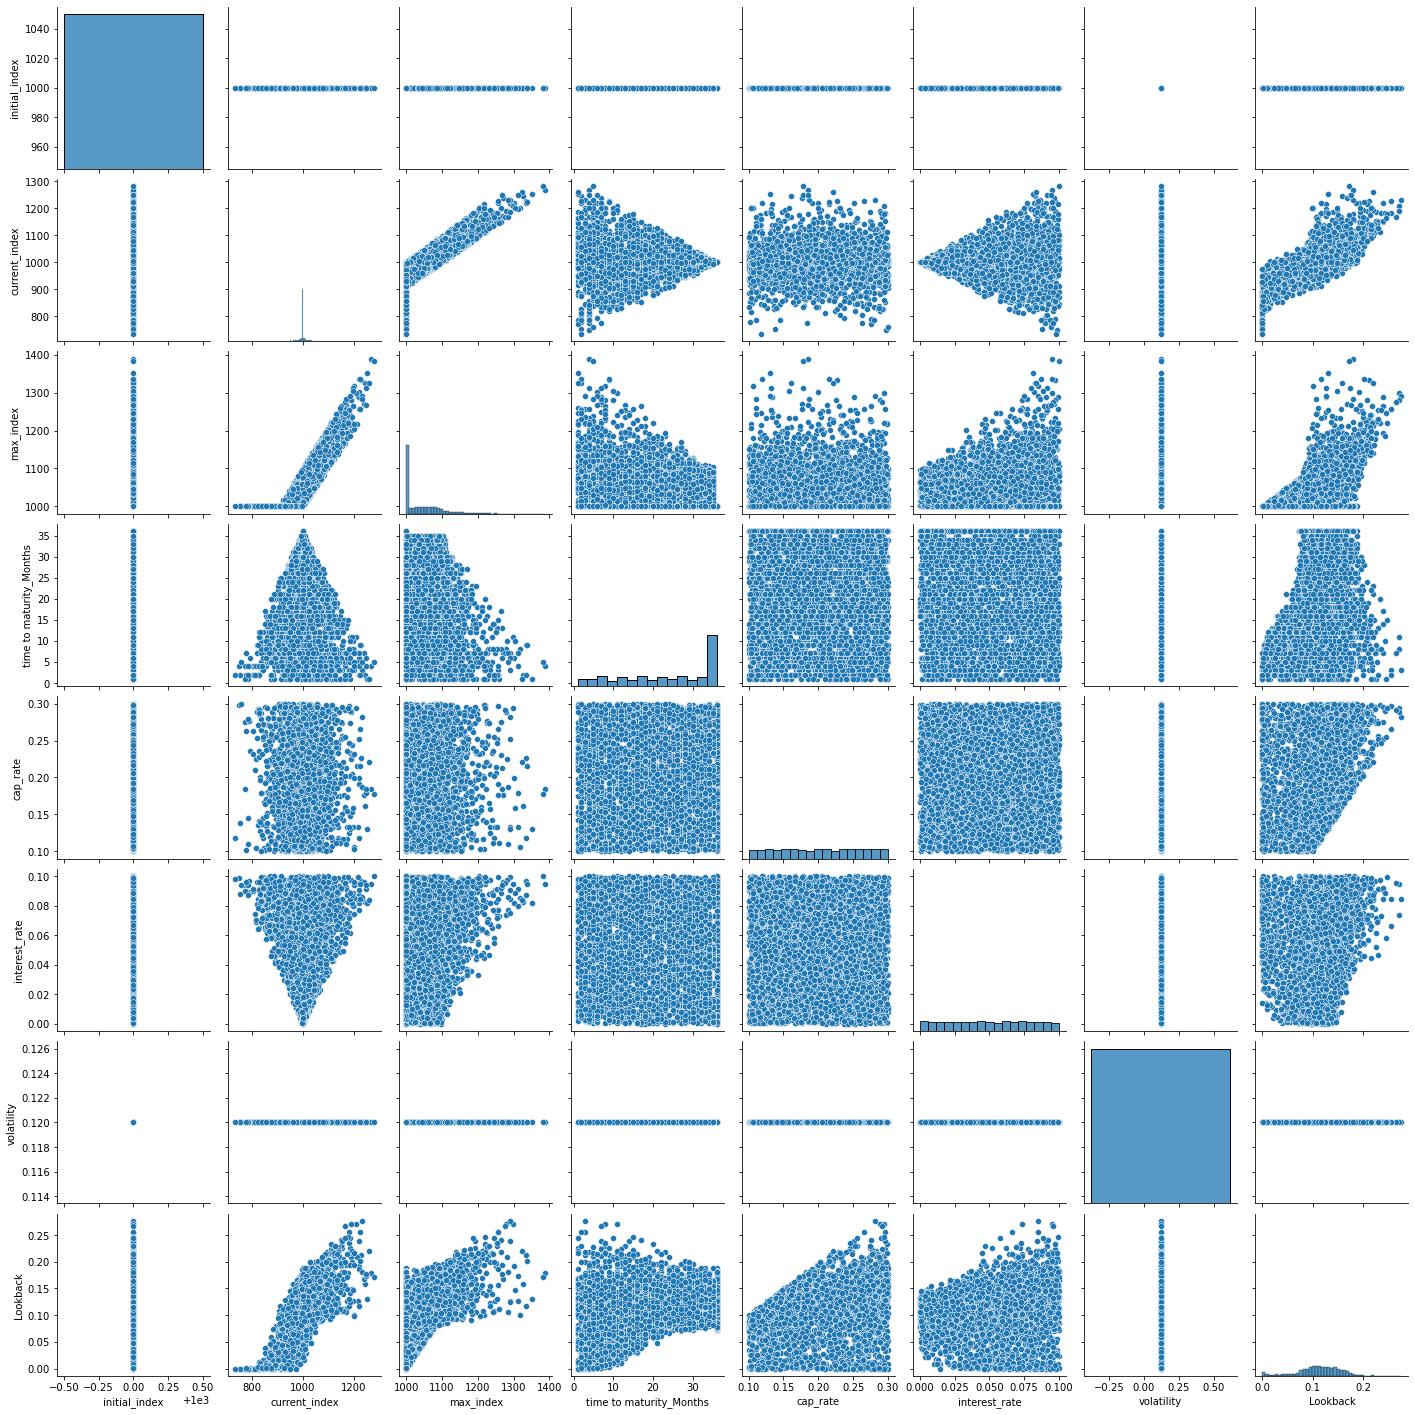

In [3]:
# Seaborn visualization library
#df = df.drop(columns = ["initial_index","volatility"])
import seaborn as sns
# Create the default pairplot
sns.pairplot(df)
plt.savefig("pairplot.png",dpi=300, bbox_inches = "tight")

<AxesSubplot:xlabel='Lookback', ylabel='cap_rate'>

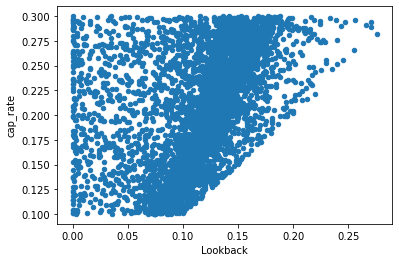

In [4]:
%matplotlib inline
df.plot.scatter(x="Lookback", y="cap_rate")

In [5]:
df["cap_rate"].corr(df["Lookback"])

df["current_index"].corr(df["Lookback"])

df["max_index"].corr(df["Lookback"])

0.4078083631906189

In [6]:
#from pandas_profiling import ProfileReport
#data_profile = ProfileReport(df)
#data_profile.to_file(output_file ='FIA_data_5K_Antithetics.html')


In [7]:
#my_report = sv.analyze(df)
#my_report.show_html()


## Feature Engineering

In [8]:
# Create Feature 1
#Create a call option with a strike of the initial index and a current stock price of the max index 
#(indicates how ITM the option is)


def Euro_Vanilla_Call(S,K,t,T,r,sigma):
    #S: Spot price 
    #K: Strike Price
    #T: time to maturity
    #r: continuous effective risk free rate
    #sigma: Implied Volatility
    
    d1 = (np.log(S/K) + (r + (sigma**2)*.5)*(T-t)) / (sigma * math.sqrt(T-t))
    d2 = d1 - sigma * math.sqrt((T-t))
    
    call = S * norm.cdf(d1,0,1.0) - K *  np.exp(-r*(T-t)) *  norm.cdf(d2,0,1.0)
    
    return call / K


df["Black_Scholes_Call"] = df.apply(lambda x: Euro_Vanilla_Call(x["max_index"], x["initial_index"] ,0,x["time to maturity_Months"]/12  ,x["interest_rate"],x["volatility"]),axis =1)


# Create Feature 2-4 - express columns as a ratio to initial and current
df["max_index"] = df["max_index"] / df["current_index"]
df["current_index"] = df["current_index"] / df["initial_index"]
df["ratio_max_to_current"] = df["max_index"] / df["current_index"]

df = df.drop(columns = ["initial_index"])

df = df.rename(columns={"current_index":"current_ratio_to_initial","max_index":"max_ratio_to_initial"})
df.columns

Index(['current_ratio_to_initial', 'max_ratio_to_initial',
       'time to maturity_Months', 'cap_rate', 'interest_rate', 'volatility',
       'Lookback', 'Black_Scholes_Call', 'ratio_max_to_current'],
      dtype='object')

In [9]:
input_cols = ['ratio_max_to_current','current_ratio_to_initial', 'max_ratio_to_initial', 'time to maturity_Months', 'cap_rate',
       'interest_rate', 'Black_Scholes_Call']
target = ['Lookback']


In [17]:
#scaler_min_max = MinMaxScaler()
#scaler_min_max_y = MinMaxScaler()

#scale training and testing data
#Xminmax = scaler_min_max.fit_transform(df[input_cols])
#yminmax = scaler_min_max_y.fit_transform(df[target])

Xscaler = StandardScaler()

X = Xscaler.fit_transform(df[input_cols])
y = df[target].values

#joblib.dump(Xscaler, path +"/xscaler.save") 
#joblib.dump(yscaler, path +"/yscaler.save")

,Lookback
0,0.129738
1,0.153433
2,0.166349
3,0.153207
4,0.158904
...,...
4995,0.164599
4996,0.180008
4997,0.081706
4998,0.059718


# Multivariate Regression Model

Train, Test Split

In [18]:
seed = 7
test_size = 0.2
x_train_MLS, x_test_MLS, y_train_MLS, y_test_MLS = train_test_split(X, y, test_size=test_size, random_state=seed)

Declare and Train Model

In [12]:
regr = linear_model.LinearRegression()
regr.fit(x_train_MLS, y_train_MLS)
y_pred_MLS= regr.predict(x_test_MLS)

Evaluate Results

In [19]:
print(regr.coef_)

r2 = str(regr.score(x_test_MLS,y_test_MLS))

print(" The R^2 is " + r2)  


print(" The MAE is " + str(mean_absolute_error(y_pred_MLS,y_test_MLS)))

[[-0.01954713  0.0203632   0.0212813   0.02355125  0.01966212  0.00479617
   0.00059367]]
 The R^2 is 0.8667762192959407
 The MAE is 0.011636400144247931


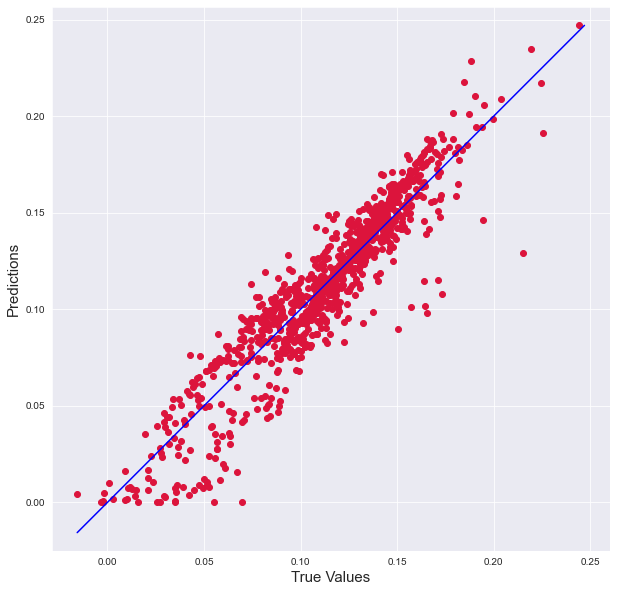

In [37]:
def plot_Actual_to_Predicted(y_pred,y_actual):
    plt.figure(figsize=(10,10))
    plt.scatter(y_pred, y_actual, c='crimson')
    #plt.yscale('log')
    #plt.xscale('log')
    p1 = max(max(y_pred), max(y_actual))
    p2 = min(min(y_pred), min(y_actual))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    return plt.show()
    
    
plot_Actual_to_Predicted(y_pred_MLS, y_test_MLS)  
#plt.savefig("MLS_AtoE.png",dpi=300, bbox_inches = "tight")



In [21]:
def plotPred(y_actual,y_predicted,col_idx = 0,sort_values = True,estimator = None,frac = None, bw = 1,verbose = True):
        
        plots = {}
    
        y_actual = pd.DataFrame(y_actual.copy())
        y_predicted = pd.DataFrame(y_predicted.copy())
        
        col = y_actual.columns[col_idx]

        df_plt = pd.DataFrame(y_actual[y_actual.columns[col_idx]])
        df_plt['y_predicted'] = y_predicted[y_predicted.columns[col_idx]]
        df_plt.columns = ['y_actual','y_predicted']
        df_plt = df_plt.dropna()
        
        df_plt['error'] = df_plt['y_predicted'] - df_plt['y_actual']
        df_plt['error_p'] = df_plt['y_predicted']/df_plt['y_actual'] - 1
        df_plt = df_plt.replace([np.inf, -np.inf, np.nan], 0)
        
        if sort_values:
            df_plt = df_plt.sort_values(by = 'y_actual').reset_index(drop = True)

       
        plots['dist'] = density_plots(df_plt, att_names = ['y_actual','y_predicted'], bw = bw,x_lab = col)
        plots['error'] = density_plots(df_plt, att_names = ['error'],bw = bw,x_lab = col)
        plots['time'] = time_plots(df_plt, att_names = ['y_actual','y_predicted'],frac=frac,estimator=estimator,y_lab = col)
        plots['dist_w_error'] = plotDistributionWithError(df_plt,
                                                                            col = 'y_actual',
                                                                            error_col = 'error_p',
                                                                            n_bins = 30)
        

        if verbose:
            for k,v in plots.items():
                p = v.gcf()
                p.show()
        
        return plots


In [22]:
def density_plots(df, att_names, bw = 1, x_lab = 'Value'):
    
        color_list = sns.color_palette("hls", len(att_names))
        sns.set_style('darkgrid')
        fig, axes = plt.subplots(figsize = (15,9))

        for i in range(len(att_names)):
            p1=sns.kdeplot(np.array(df['{att_name}'.format(att_name = att_names[i])]),
                           bw_adjust = bw,
                           shade=True, 
                           color=color_list[i])
            
        legend = dict(zip(att_names,color_list[:len(att_names)]))
        legend_markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend.values()]
        
        plt.legend(legend_markers, legend.keys(), numpoints=1)
        plt.title('Density Plot - {} vs. Proportion'.format(x_lab))
        plt.xlabel(x_lab)
        plt.ylabel('Proportion (% Obs)')
                
        return plt
        



In [23]:
def time_plots(df, att_names, err_style = 'band', estimator=np.median, ci=95,frac = 0.1, x = '',y_lab = 'Value',x_lab = 'Index'):
        
        if isinstance(frac,float):
            df = df.sample(frac = frac,replace = False)

        if x == '':
            x = df.index
        else:
            x_lab = x
        
        color_list = sns.color_palette("hls", len(att_names))
        sns.set_style('darkgrid')
        fig, axes = plt.subplots(figsize = (15,9))
        
        for i in range(len(att_names)):
            p1=sns.lineplot(data = df,
                            y = att_names[i],
                            x = x,
                            color = color_list[i],
                            err_style = err_style,
                            estimator = estimator,
                            ci = ci)
            
        
        legend = dict(zip(att_names,color_list[:len(att_names)]))
        legend_markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend.values()]
        
        plt.legend(legend_markers, legend.keys(), numpoints=1)
        plt.title('Line Plot - {} vs. {}'.format(y_lab,x_lab))
        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
            
        return plt
    


In [24]:
def plotDistributionWithError(df,col = 'y_actual',error_col = 'error_p',n_bins = 30):
        
        sns.set_style('darkgrid')
        fig, ax_1 = plt.subplots(figsize = (15,9))
        ax_2 = ax_1.twinx()
        
        bin_centers, bin_means, bin_count = getVariableBins(df, x_col = col, 
                                                                              error_col = error_col, 
                                                                              n_bins = n_bins)
        
        sns.scatterplot(x=bin_centers, y=bin_means,
                        ax = ax_1,size = bin_count)
        sns.histplot(data=df, x=col, bins=n_bins,
                     color = sns.color_palette("rocket")[0])
        fig.tight_layout()
        
        plt.title('Plot - {} vs. {}'.format(col,error_col))
        plt.xlabel(col)
        
        return plt


In [25]:
def getVariableBins(df,
                        x_col = 'actual', 
                        error_col = 'error_p', 
                        n_bins = 30):
        
        x_bin = df[x_col]
        values = df[error_col]
        bin_means, bin_edges, _=stats.binned_statistic(x_bin, values,
                                                       'mean',
                                                        bins=n_bins)
        bin_count, _, _ = stats.binned_statistic(x_bin,values, 
                                                 'count',
                                                  bins=n_bins)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        
        return bin_centers, bin_means, bin_count

C:\Users\ED397JT\AppData\Local\Temp/ipykernel_3268/2347685229.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


{'dist': <module 'matplotlib.pyplot' from 'C:\\Users\\ED397JT\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 'error': <module 'matplotlib.pyplot' from 'C:\\Users\\ED397JT\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 'time': <module 'matplotlib.pyplot' from 'C:\\Users\\ED397JT\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 'dist_w_error': <module 'matplotlib.pyplot' from 'C:\\Users\\ED397JT\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>}

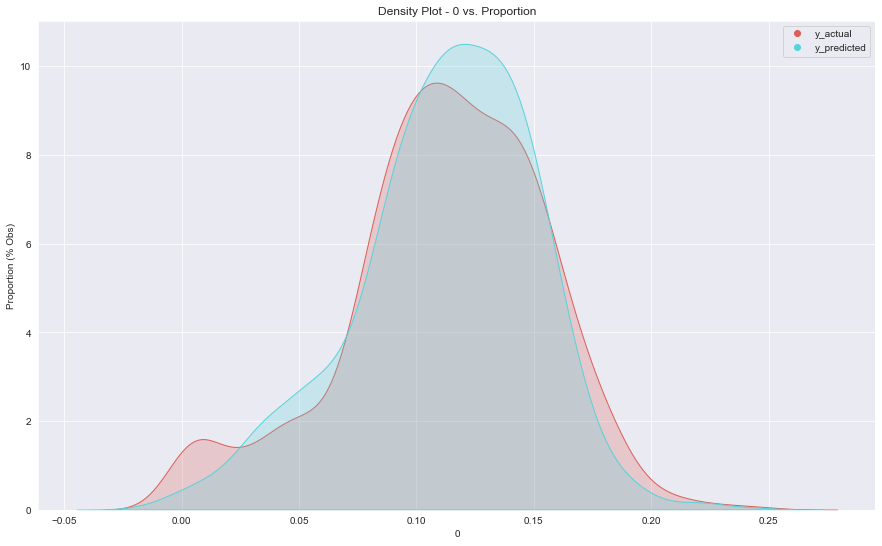

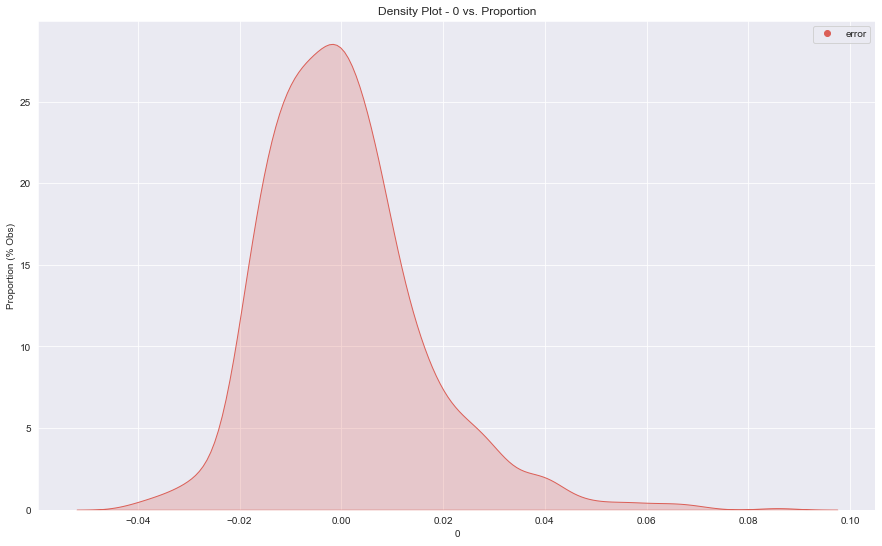

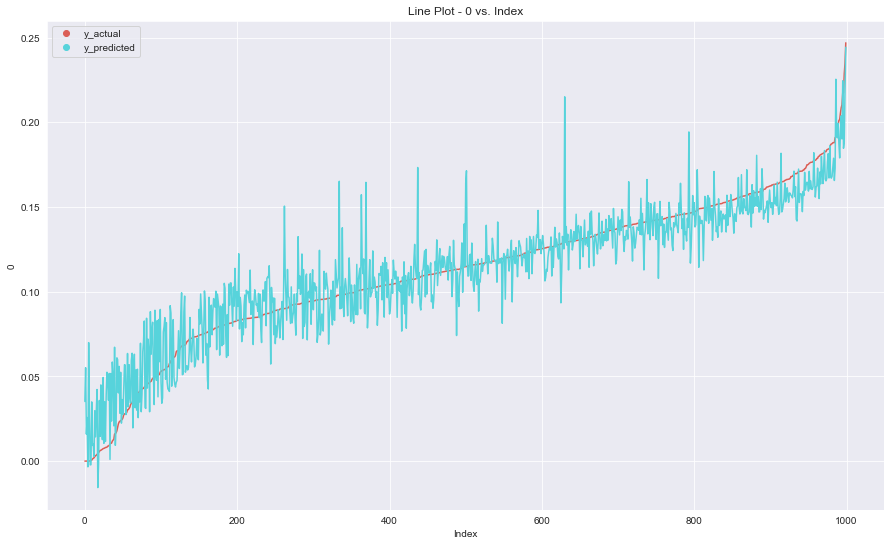

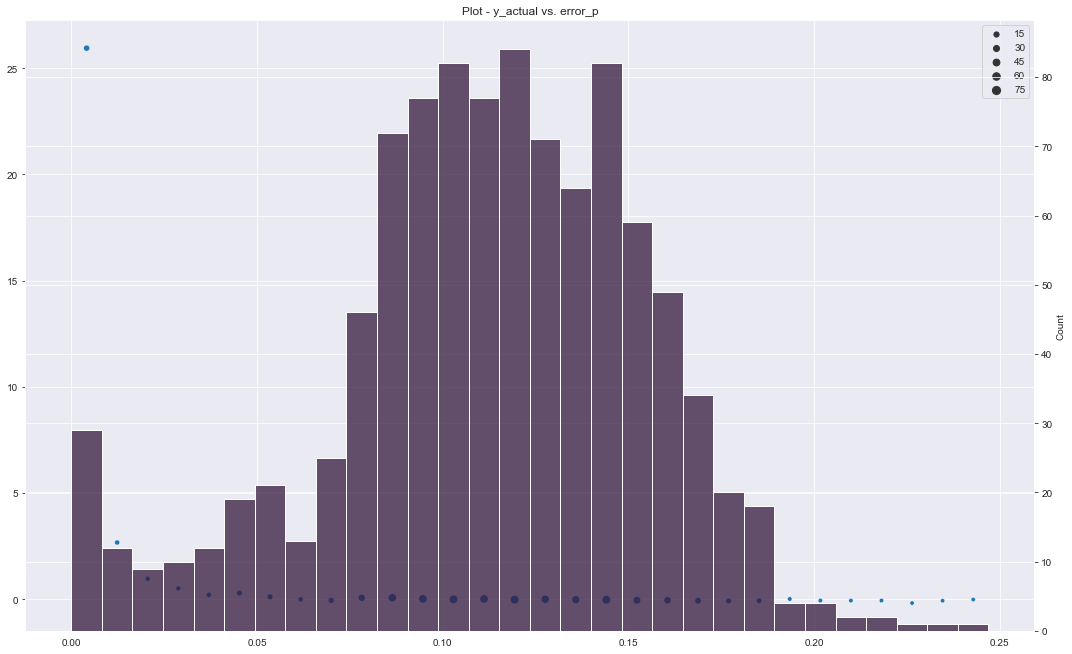

In [26]:
plotPred(y_test_MLS,y_pred_MLS)

#plt.savefig("MLS_error_2.png",dpi=300, bbox_inches = "tight")

# Neural Network

### First NN

Train, Test Split

In [27]:
#Base Neural Network Model

seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)




Define Baseline NN Model

In [30]:
#define baseline model

def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(50, input_dim=7, kernel_initializer='normal', activation='relu'))
  model.add(Dense(100, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model
# evaluate model
dens_network_50 = KerasRegressor(model=baseline_model, epochs=n_epochs, batch_size=n_batch_size, verbose=1)


Evaluate Model with K-Fold Validation

In [31]:
#Run K-Fold Validation
kfold = KFold(n_splits=5)
results = cross_val_score(dens_network_50,X_train, y_train, cv=kfold)


Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 4.4632e-04
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 2.1925e-04
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 1.0921e-04
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 5.4148e-05
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 2.9924e-05
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 2.1742e-05
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 1.9439e-05
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 1.6441e-05
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 1.5063e-05
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 1.4806e-05
Epoch 12/100
32/32 [==============================] - 0s 1ms/step - loss: 1.31

32/32 [==============================] - 0s 2ms/step - loss: 1.5386e-06
Epoch 98/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5123e-06
Epoch 99/100
32/32 [==============================] - 0s 2ms/step - loss: 1.8458e-06
Epoch 100/100
8/8 [==============================] - 0s 1ms/step
Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 4.5722e-04
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 2.0437e-04
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 1.1796e-04
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 6.9405e-05
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 4.1640e-05
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 2.6377e-05
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 2.2150e-05
Epoch 9/100
32/32 [======

32/32 [==============================] - 0s 1ms/step - loss: 1.5021e-06
Epoch 93/100
32/32 [==============================] - 0s 1ms/step - loss: 1.5836e-06
Epoch 94/100
32/32 [==============================] - 0s 1ms/step - loss: 2.1015e-06
Epoch 95/100
32/32 [==============================] - 0s 1ms/step - loss: 2.0159e-06
Epoch 96/100
32/32 [==============================] - 0s 1ms/step - loss: 1.9795e-06
Epoch 97/100
32/32 [==============================] - 0s 1ms/step - loss: 1.9310e-06
Epoch 98/100
32/32 [==============================] - 0s 1ms/step - loss: 2.0632e-06
Epoch 99/100
32/32 [==============================] - 0s 1ms/step - loss: 2.0672e-06
Epoch 100/100
8/8 [==============================] - 0s 1ms/step
Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 4.7887e-04
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 2.3023e-04
Epoch 4/100
32/32 [=

32/32 [==============================] - 0s 2ms/step - loss: 1.7258e-06
Epoch 88/100
32/32 [==============================] - 0s 2ms/step - loss: 1.6648e-06
Epoch 89/100
32/32 [==============================] - 0s 2ms/step - loss: 1.6591e-06
Epoch 90/100
32/32 [==============================] - 0s 2ms/step - loss: 1.6347e-06
Epoch 91/100
32/32 [==============================] - 0s 2ms/step - loss: 1.6477e-06
Epoch 92/100
32/32 [==============================] - 0s 2ms/step - loss: 1.3392e-06
Epoch 93/100
32/32 [==============================] - 0s 2ms/step - loss: 1.2466e-06
Epoch 94/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5091e-06
Epoch 95/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5872e-06
Epoch 96/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5274e-06
Epoch 97/100
32/32 [==============================] - 0s 2ms/step - loss: 1.3660e-06
Epoch 98/100
32/32 [==============================] - 0s 2ms/step - loss: 1.79

32/32 [==============================] - 0s 2ms/step - loss: 1.5343e-06
Epoch 84/100
32/32 [==============================] - 0s 1ms/step - loss: 1.4824e-06
Epoch 85/100
32/32 [==============================] - 0s 1ms/step - loss: 1.5601e-06
Epoch 86/100
32/32 [==============================] - 0s 1ms/step - loss: 1.5416e-06
Epoch 87/100
32/32 [==============================] - 0s 1ms/step - loss: 1.3299e-06
Epoch 88/100
32/32 [==============================] - 0s 1ms/step - loss: 1.8966e-06
Epoch 89/100
32/32 [==============================] - 0s 2ms/step - loss: 1.8938e-06
Epoch 90/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5414e-06
Epoch 91/100
32/32 [==============================] - 0s 2ms/step - loss: 1.7346e-06
Epoch 92/100
32/32 [==============================] - 0s 2ms/step - loss: 1.6229e-06
Epoch 93/100
32/32 [==============================] - 0s 2ms/step - loss: 1.7132e-06
Epoch 94/100
32/32 [==============================] - 0s 2ms/step - loss: 1.44

32/32 [==============================] - 0s 2ms/step - loss: 2.2154e-06
Epoch 80/100
32/32 [==============================] - 0s 2ms/step - loss: 1.6173e-06
Epoch 81/100
32/32 [==============================] - 0s 2ms/step - loss: 1.9859e-06
Epoch 82/100
32/32 [==============================] - 0s 2ms/step - loss: 1.7034e-06
Epoch 83/100
32/32 [==============================] - 0s 2ms/step - loss: 2.1055e-06
Epoch 84/100
32/32 [==============================] - 0s 2ms/step - loss: 2.0410e-06
Epoch 85/100
32/32 [==============================] - 0s 2ms/step - loss: 1.8909e-06
Epoch 86/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5956e-06
Epoch 87/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5853e-06
Epoch 88/100
32/32 [==============================] - 0s 2ms/step - loss: 1.7325e-06
Epoch 89/100
32/32 [==============================] - 0s 2ms/step - loss: 1.5333e-06
Epoch 90/100
32/32 [==============================] - 0s 2ms/step - loss: 1.44

In [32]:
print("Baseline: %.5f (%.5f) MSE" % (results.mean(), results.std()))

Baseline: 0.99878 (0.00021) MSE


Fit Initial Model, Evaluate Train Results

In [33]:
# Model Fitting & Evaluation

from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 
import math

dens_network_50.fit(X_train, y_train)
train_pred=dens_network_50.predict(X_train)

Epoch 1/100
40/40 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 2/100
40/40 [==============================] - 0s 1ms/step - loss: 3.5510e-04
Epoch 3/100
40/40 [==============================] - 0s 1ms/step - loss: 1.4708e-04
Epoch 4/100
40/40 [==============================] - 0s 1ms/step - loss: 5.8087e-05
Epoch 5/100
40/40 [==============================] - 0s 1ms/step - loss: 2.8028e-05
Epoch 6/100
40/40 [==============================] - 0s 1ms/step - loss: 2.0741e-05
Epoch 7/100
40/40 [==============================] - 0s 1ms/step - loss: 1.6426e-05
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 1.4137e-05
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 1.2254e-05
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 1.1560e-05
Epoch 11/100
40/40 [==============================] - 0s 2ms/step - loss: 1.0027e-05
Epoch 12/100
40/40 [==============================] - 0s 2ms/step - loss: 8.91

40/40 [==============================] - 0s 2ms/step - loss: 1.1250e-06
Epoch 98/100
40/40 [==============================] - 0s 1ms/step - loss: 1.1770e-06
Epoch 99/100
40/40 [==============================] - 0s 2ms/step - loss: 1.2442e-06
Epoch 100/100
40/40 [==============================] - 0s 1ms/step


In [34]:
def model_performance(Y_Actual,Y_Pred):
    print("R-Squared Coefficient: ", "{:.5f}".format(r2_score(Y_Actual, Y_Pred)))
    print("Mean Square Error: ", "{:.5f}".format(mean_squared_error(Y_Actual,Y_Pred)))
    print("Mean Absolute Error: ", "{:.5f}".format(mean_absolute_error(Y_Actual,Y_Pred)))    
    RMSE = math.sqrt(mean_squared_error(Y_Actual,Y_Pred))
    print("Root Mean Square Error: ", "{:.5f}".format(RMSE))
    return

model_performance(y_train, train_pred)

R-Squared Coefficient:  0.99920
Mean Square Error:  0.00000
Mean Absolute Error:  0.00091
Root Mean Square Error:  0.00122


Evaluate Test Results

In [35]:
test_pred=dens_network_50.predict(X_test)

model_performance(y_test, test_pred)


10/10 [==============================] - 0s 1ms/step
R-Squared Coefficient:  0.99888
Mean Square Error:  0.00000
Mean Absolute Error:  0.00103
Root Mean Square Error:  0.00143


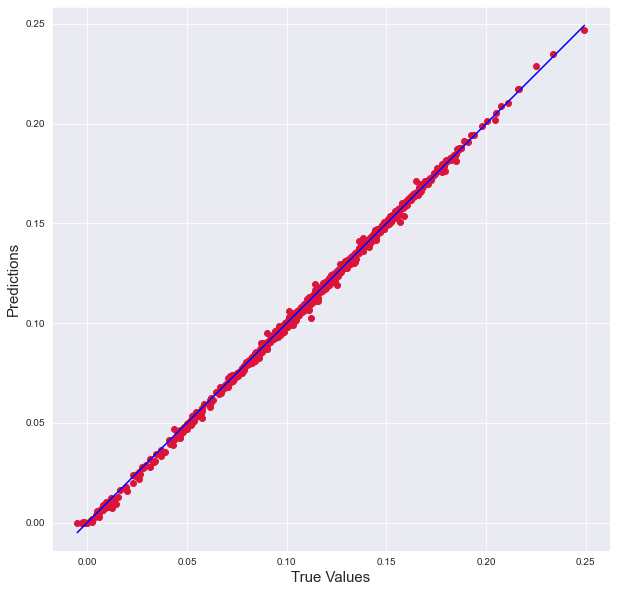

In [36]:
## plot predicted values

plot_Actual_to_Predicted(test_pred, y_test)

#plt.savefig("NN1_AtoE1.png" ,dpi=300 ,bbox_inches = "tight")


C:\Users\ED397JT\AppData\Local\Temp/ipykernel_3268/2347685229.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


{'dist': <module 'matplotlib.pyplot' from 'C:\\Users\\ED397JT\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 'error': <module 'matplotlib.pyplot' from 'C:\\Users\\ED397JT\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 'time': <module 'matplotlib.pyplot' from 'C:\\Users\\ED397JT\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 'dist_w_error': <module 'matplotlib.pyplot' from 'C:\\Users\\ED397JT\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>}

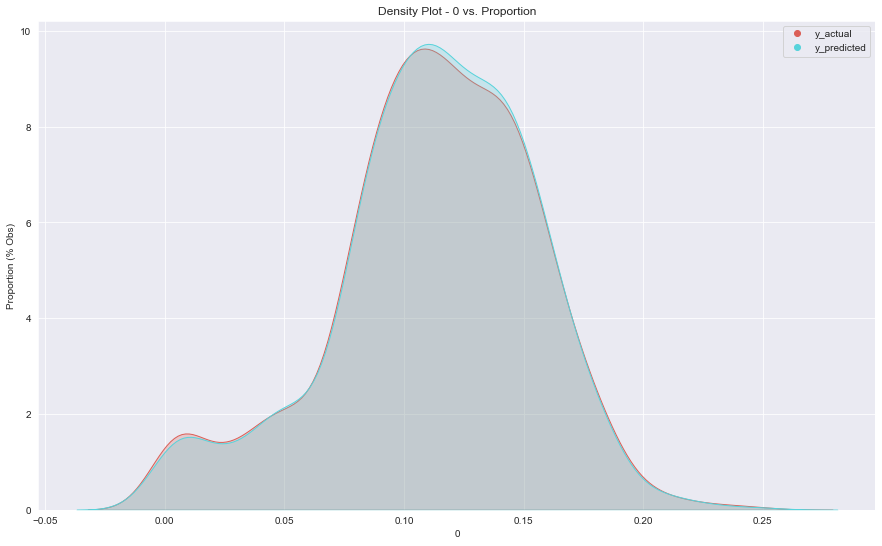

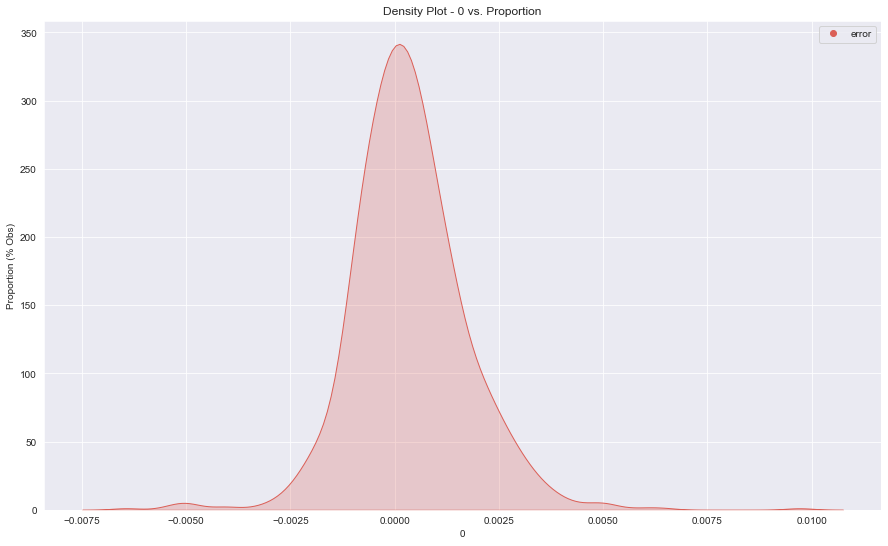

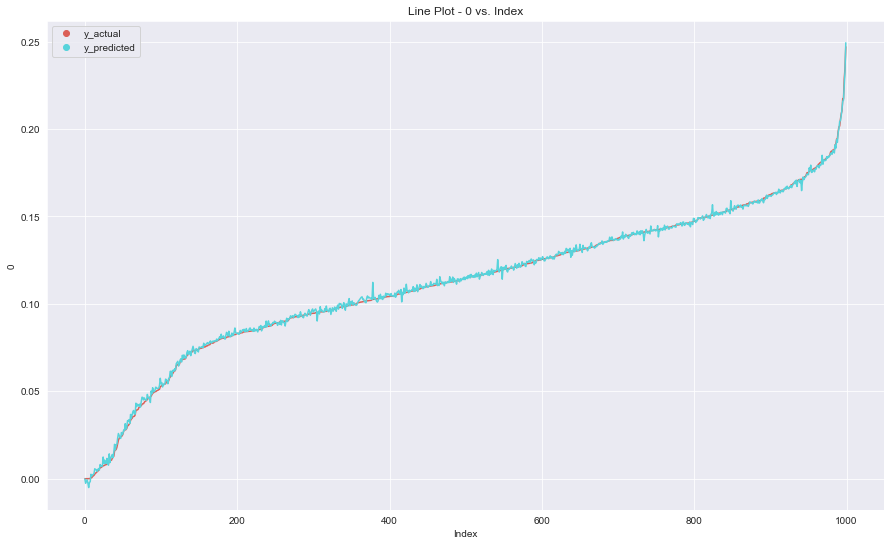

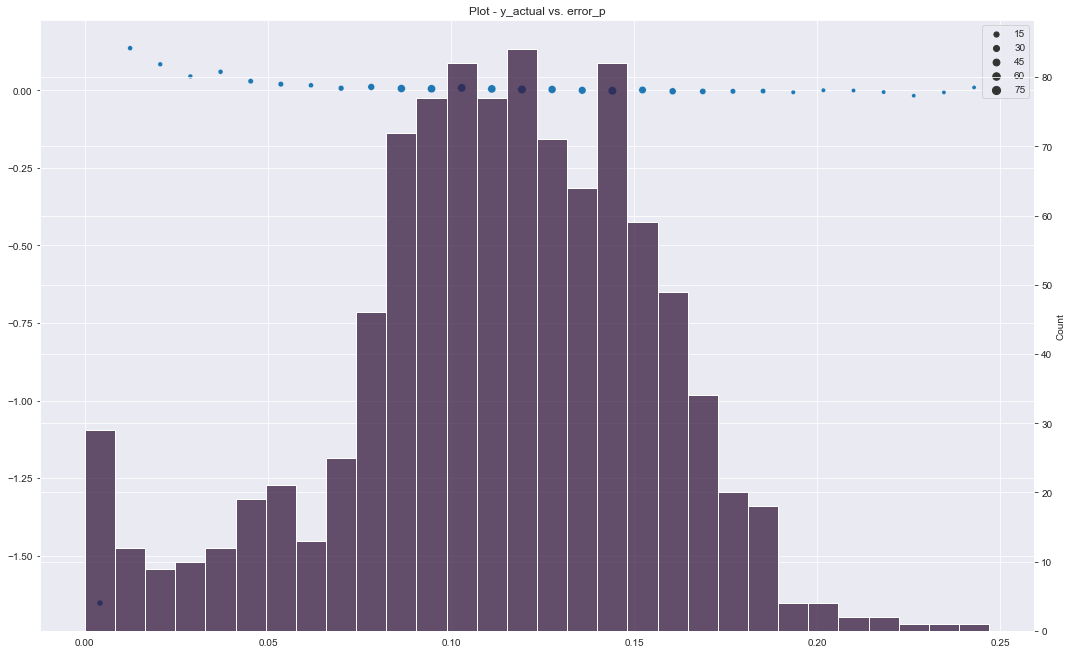

In [38]:
plotPred(y_test,test_pred)

#plt.savefig("NN1_error.png",dpi=300, bbox_inches = "tight")

### Neural Network with Modified Topology

Train,Test Split

In [ ]:
#Base Neural Network Model

seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# turns data from pandas dataframe to numpy array




Define NN Model

In [ ]:
#define baseline model

def second_model():
	# create model
  model = Sequential()
  model.add(Dense(25, input_dim=7, kernel_initializer='normal', activation='relu'))
  model.add(Dense(12, kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model
# evaluate model
dens_NN_25 = KerasRegressor(model=second_model, epochs=n_epochs, batch_size=n_batch_size, verbose=1)


Evaluate Model with K-Fold Validation

In [ ]:
#Run K-Fold Validation
kfold = KFold(n_splits=5)
results = cross_val_score(dens_NN_25,X_train, y_train, cv=kfold)

In [ ]:
print("Baseline: %.5f (%.5f) MSE" % (results.mean(), results.std()))

Fit Model, Evaluate Train Results

In [ ]:
# Model Fitting & Evaluation

dens_NN_25.fit(X_train, y_train)
train_pred_2=dens_NN_25.predict(X_train)

In [ ]:
model_performance(y_train, train_pred_2)



Evaluate Test Results

In [ ]:
test_pred_2 = dens_NN_25.predict(X_test)

model_performance(y_test, test_pred_2)

In [ ]:
## plot predicted values


plot_Actual_to_Predicted(test_pred, y_test)


plt.savefig("NN2_AtoE.png",dpi=300, bbox_inches = "tight")


In [ ]:
plotPred(y_test,test_pred)

plt.savefig("NN2_AtoE_2.png",dpi=300, bbox_inches = "tight")

## XG Boost

### XG Boost without Feature Engineering

Train, Test Split & Scale Data

In [ ]:
## Try XG Boost

seed = 7
test_size = 0.2
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(X, y, test_size=test_size, random_state=seed)





Declare and Train Model, Predict Results

In [ ]:
xgboost = xgb.XGBRegressor(objective="reg:squarederror")
xgboost .fit(X_train_xg, y_train_xg)


y_pred_xg = xgboost.predict(X_test_xg)







Evaluate Model

In [ ]:
model_performance(y_test_xg, y_pred_xg)

In [ ]:
plot_Actual_to_Predicted(y_pred_xg, y_test_xg)


plt.savefig("xg_AtoE.png",dpi=300, bbox_inches = "tight")

In [ ]:
plotPred(y_test_xg,y_pred_xg)

plt.savefig("xg_AtoE_2.png",dpi=300, bbox_inches = "tight")

Evaluate Feature Importances

In [ ]:
xgboost.get_booster().feature_names = input_cols 
plot_importance(xgboost)

### XG Boost with Feature Engineering

Train, Test Split , Retrain Model

In [ ]:
# # Remove Volatility from X Inputs
# seed = 7
# test_size = 0.2
# X_train_xg2, X_test_xg2, y_train_xg2, y_test_xg2 = train_test_split(X[:,1:], y, test_size=test_size, random_state=seed)
# xgboost_2 = xgb.XGBRegressor(objective="reg:squarederror")
# xgboost_2.fit(X_train_xg2, y_train_xg2)
# y_pred_xg2= xgboost_2.predict(X_test_xg2)


Evaluate Retrained Model

In [ ]:
# model_performance(y_test_xg2, y_pred_xg2)

In [ ]:
# plot_Actual_to_Predicted(y_pred_xg2, y_test_xg2)

Plot Feature Importance

In [ ]:
# input_cols.remove('volatility')


In [ ]:
# xgboost_2.get_booster().feature_names = input_cols
# plot_importance(xgboost_2)
# plt.savefig("featureimportance.png",dpi=300, bbox_inches = "tight")

